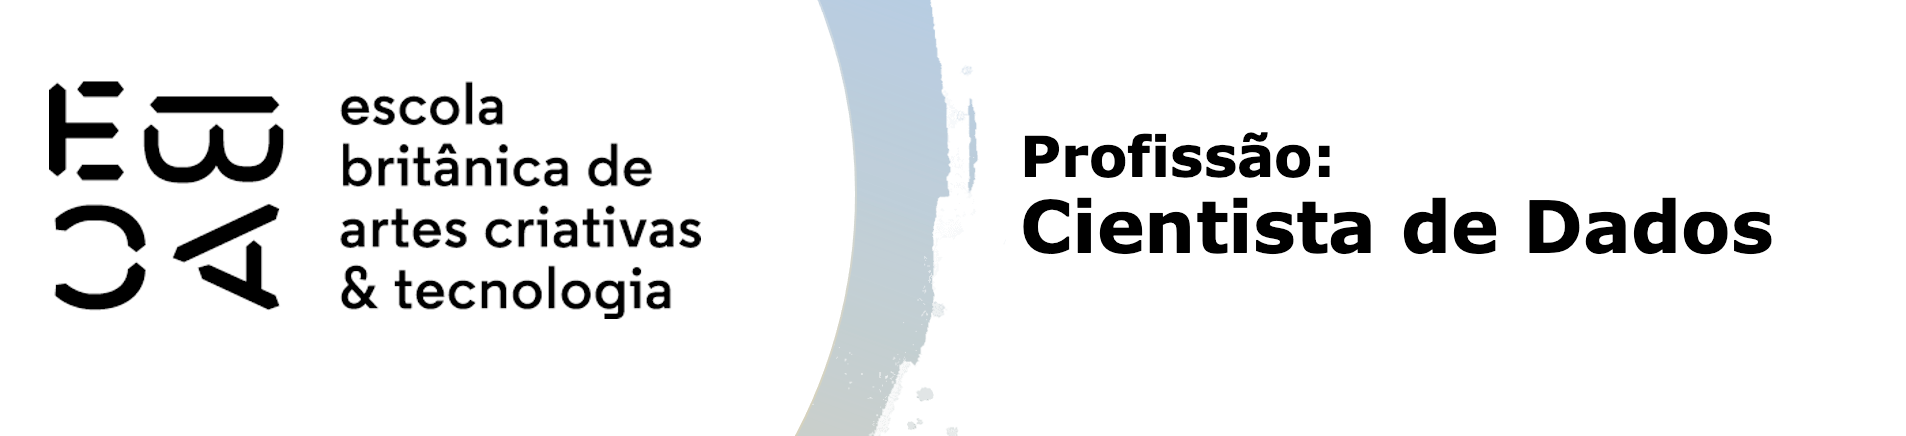

---

<!-- # **Profissão: Cientista de Dados** -->
### **Módulo 35** | Regressão IV | Exercício I

**Aluno:** [Marcio da Silva](https://www.linkedin.com/in/marcio-d-silva/)<br>
**Data:** 21 de outubro de 2024.

---


# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import numpy as np      # Biblioteca para operações matemáticas e manipulação de arrays
import pandas as pd     # Biblioteca para análise e manipulação de dados (DataFrames)

import matplotlib.pyplot as plt  # Biblioteca para criação de gráficos
import seaborn as sns            # Biblioteca para visualização avançada de dados, integrada ao Matplotlib

from sklearn.model_selection import train_test_split  # Função para dividir os dados em conjuntos de treino e teste

import statsmodels.api as sm           # Biblioteca para construção de modelos estatísticos
import statsmodels.formula.api as smf  # Interface para criar modelos estatísticos utilizando fórmulas

from scipy.interpolate import interp1d  # Função para interpolação de dados (preenchimento de valores ausentes)

from sklearn.metrics import r2_score  # Função para calcular o coeficiente de determinação (R²), que avalia a qualidade do modelo

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif  
# Função para calcular o Fator de Inflação da Variância (VIF), utilizada para detectar multicolinearidade entre variáveis


In [5]:
#Carregando arquivo CSV e removendo a coluna 'Index' pois não será necessaria.
df = pd.read_csv(filepath_or_buffer='database/previsao_de_renda_II.csv').drop(columns='index')

#Carregando informações sobre o DF.
df.info()

#Mostrando conteúdo do DF.
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(2), object(8)
memory usage: 74.4+ MB


,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40
749996,2016-03-01,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,NaN,2.0,4084.37
749997,2016-03-01,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66
749998,2016-03-01,F,S,S,1,Empresário,Superior completo,União,Casa,28,8.219178,3.0,9159.49


---

In [6]:
def amostra(data: pd.DataFrame, column: str, perc: float = 1, seed: int = None) -> pd.DataFrame:
    """
    Retorna uma amostra de um DataFrame com base na porcentagem especificada.

    Parameters:
    - data (pd.DataFrame): O DataFrame a ser amostrado.
    - column (str): Coluna para agrupar os dados.
    - perc (float): Porcentagem da amostra (0 a 1, padrão é 1).
    - seed (int, optional): Semente para reprodutibilidade.

    Returns:
    - pd.DataFrame: DataFrame contendo a amostra.

    Raises:
    - ValueError: Se perc não estiver entre 0 e 1.
    - KeyError: Se a coluna não existir no DataFrame.

    Examples:
    >>> df = pd.DataFrame({'A': ['foo', 'foo', 'bar', 'bar', 'foo'], 'B': [1, 2, 3, 4, 5]})
    >>> amostra(df, 'A', perc=0.5, seed=42)
    """
    
    if not (0 < perc <= 1):
        raise ValueError("O parâmetro perc deve estar entre 0 e 1.")
    if column not in data.columns:
        raise KeyError(f"A coluna '{column}' não existe no DataFrame.")

    new_df = (data.set_index(column)
                  .groupby(column, group_keys=False)
                  .apply(lambda x: x.sample(frac=perc, random_state=seed))
                  .reset_index())
    
    print(f"Tamanho do DataFrame original:\n{data.groupby(column).size()}\nTotal: {len(data)} linhas\n")
    print(f"Tamanho do novo DataFrame:\n{new_df.groupby(column).size()}\nTotal: {len(new_df)} linhas\n")
    
    return new_df


In [12]:
# Criando uma cópia do DataFrame e adicionando a coluna 'renda_log'
df_ = df.copy()
df_["renda_log"] = np.log(df_.renda)

# Amostrando 1% dos dados agrupados pela coluna 'data_ref'
df_ = amostra(df_, "data_ref", perc=0.01, seed=420)

# Exibindo o DataFrame resultante
df_


Tamanho do DataFrame original:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
dtype: int64
Total: 750000 linhas

Tamanho do novo DataFrame:
data_ref
2015-01-01    500
2015-02-01    500
2015-03-01    500
2015-04-01    500
2015-05-01    500
2015-06-01    500
2015-07-01    500
2015-08-01    500
2015-09-01    500
2015-10-01    500
2015-11-01    500
2015-12-01    500
2016-01-01    500
2016-02-01    500
2016-03-01    500
dtype: int64
Total: 7500 linhas



,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log
0,2015-01-01,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,9935.03,9.203822
1,2015-01-01,F,S,S,0,Empresário,Médio,Casado,Casa,47,5.528767,2.0,10665.10,9.274732
2,2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,12.526027,1.0,15899.37,9.674035
3,2015-01-01,M,S,S,0,Assalariado,Superior completo,Separado,Casa,40,1.945205,1.0,3442.69,8.144008
4,2015-01-01,F,N,N,0,Empresário,Médio,Casado,Governamental,50,4.676712,2.0,1619.86,7.390095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,2016-03-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,32,0.841096,1.0,1263.60,7.141720
7496,2016-03-01,F,N,S,0,Empresário,Superior completo,Solteiro,Casa,50,6.687671,1.0,850.94,6.746342
7497,2016-03-01,F,S,N,1,Servidor público,Superior completo,Casado,Casa,38,14.712329,3.0,18671.61,9.834759
7498,2016-03-01,F,S,N,0,Assalariado,Superior completo,Solteiro,Casa,55,2.800000,1.0,638.82,6.459623


In [16]:
# Preenche valores nulos na coluna 'tempo_emprego' com a média
df_['tempo_emprego'].fillna(df_['tempo_emprego'].mean(), inplace=True)

# Exibe a contagem de valores nulos em cada coluna
df_.isna().sum()


/var/folders/30/ccp86mqj2q1cbkdw53t09hmc0000gn/T/ipykernel_4734/4114286081.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_['tempo_emprego'].fillna(df_['tempo_emprego'].mean(), inplace=True)


data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
renda_log                0
dtype: int64

In [17]:
# Divide o DataFrame em treino (80%) e teste (20%) com reprodutibilidade
df_train, df_test = train_test_split(df_, test_size=0.2, random_state=420)

# Exibe as dimensões dos DataFrames de treino e teste
print(df_train.shape)
print(df_test.shape)

(6000, 14)
(1500, 14)


---

In [18]:
# Ajusta um modelo de regressão linear e exibe um resumo dos resultados
modelo = smf.ols("renda_log ~ tempo_emprego", data=df_train).fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     3414.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:17:27   Log-Likelihood:                -8676.6
No. Observations:                6000   AIC:                         1.736e+04
Df Residuals:                    5998   BIC:                         1.737e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.0319      0.022    369.885      0.000       7.989       8.074
tempo_emprego     0.1307      0.002     58.434      0.000       0.126       0.135
==============================================================================
Omnibus:                       39.691   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.249
Skew:                           0.039   Prob(JB):                     7.34e-07
Kurtosis:                       2.673   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
%%time

# Aplica suavização LOWESS aos dados
lowess = sm.nonparametric.lowess(endog=df_train.renda_log, exog=df_train.tempo_emprego)


CPU times: user 518 ms, sys: 15.3 ms, total: 533 ms
Wall time: 598 ms


In [20]:
%%time

# Cria uma função de interpolação 1D com os dados ajustados pelo LOWESS
f_ = interp1d(lowess[:, 0], lowess[:, 1], bounds_error=False)


CPU times: user 1.54 ms, sys: 1.18 ms, total: 2.72 ms
Wall time: 5.15 ms


In [21]:
%%time

# Aplica a função de interpolação LOWESS aos dados de treino e teste
df_train["lowess"] = f_(df_train.tempo_emprego)
df_test["lowess"] = f_(df_test.tempo_emprego)


CPU times: user 7.51 ms, sys: 14.6 ms, total: 22.1 ms
Wall time: 31.9 ms


In [22]:
# Ajusta um modelo de regressão linear com 'renda_log' como dependente e 'lowess' como independente
reg_lowess = smf.ols("renda_log ~ lowess", data=df_train).fit()
reg_lowess.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     3486.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:19:28   Log-Likelihood:                -8653.8
No. Observations:                6000   AIC:                         1.731e+04
Df Residuals:                    5998   BIC:                         1.732e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0108      0.153      0.071      0.944      -0.290       0.312
lowess         0.9988      0.017     59.044      0.000       0.966       1.032
==============================================================================
Omnibus:                       40.351   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.748
Skew:                           0.042   Prob(JB):                     5.72e-07
Kurtosis:                       2.672   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

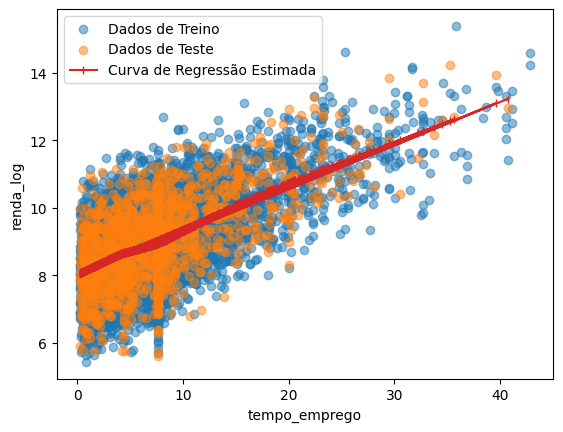

CPU times: user 288 ms, sys: 81.1 ms, total: 369 ms
Wall time: 423 ms


In [23]:
%%time

# Obtém as cores padrão do Matplotlib
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Cria um gráfico de dispersão para os dados de treino
plt.scatter(df_train.tempo_emprego, df_train.renda_log, color=colors[0], alpha=0.5, label="Dados de Treino")

# Cria um gráfico de dispersão para os dados de teste
plt.scatter(df_test.tempo_emprego, df_test.renda_log, color=colors[1], alpha=0.5, label="Dados de Teste")

# Adiciona a curva de regressão estimada
plt.plot(df_test.tempo_emprego, reg_lowess.predict(df_test), "|-", color=colors[3], label="Curva de Regressão Estimada")

# Adiciona rótulos e exibe a legenda
plt.xlabel("tempo_emprego")
plt.ylabel("renda_log")
plt.legend()
plt.show()

In [24]:
# Calcula e exibe o coeficiente de determinação (R²) para avaliar o ajuste do modelo
r2 = r2_score(df_test.renda_log, reg_lowess.predict(df_test))
print("{:.2%}".format(r2))

37.33%


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

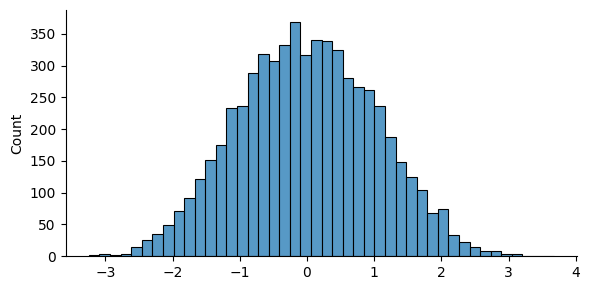

CPU times: user 302 ms, sys: 29.8 ms, total: 332 ms
Wall time: 444 ms


In [25]:
%%time

# Cria um gráfico de distribuição (histograma) dos resíduos do modelo
sns.displot(reg_lowess.resid, height=3, aspect=2)

# Exibe o gráfico
plt.show()


> Os resíduos mostrados no histograma indicam uma distribuição aproximadamente normal, apresentando um formato simétrico em torno de zero. A maioria dos valores se concentra próxima à média, com uma diminuição gradual nas extremidades. Esse padrão é característico de uma distribuição normal.

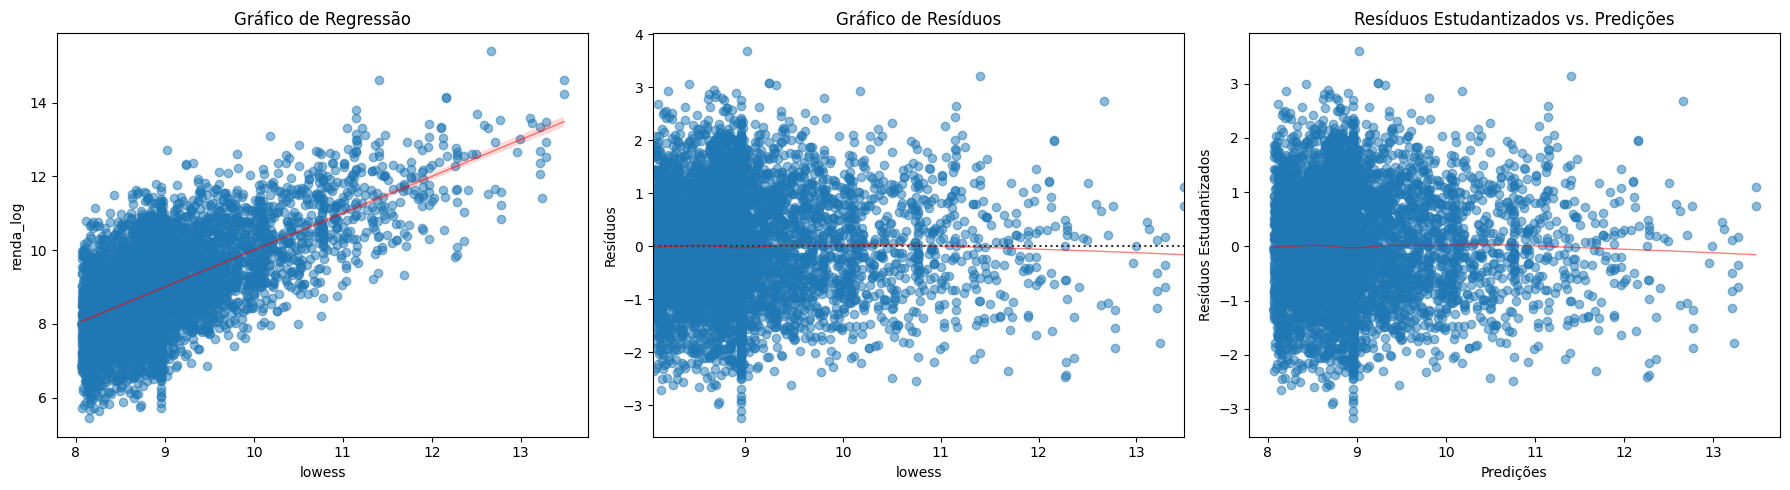

CPU times: user 7.94 s, sys: 174 ms, total: 8.11 s
Wall time: 8.41 s


In [26]:
%%time

# Verifica a suposição de independência dos resíduos com 3 gráficos
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))

# Gráfico de Regressão
sns.regplot(ax=ax[0], data=df_train, x="lowess", y="renda_log", 
            scatter_kws={"alpha": 0.5}, line_kws={"color": "red", "lw": 1, "alpha": 0.5})
ax[0].set(title="Gráfico de Regressão", xlabel="lowess", ylabel="renda_log")

# Gráfico de Resíduos
sns.residplot(ax=ax[1], data=df_train, x="lowess", y="renda_log", 
              lowess=True, scatter_kws={"alpha": 0.5}, line_kws={"color": "red", "lw": 1, "alpha": 0.5})
ax[1].set(title="Gráfico de Resíduos", xlabel="lowess", ylabel="Resíduos")

# Gráfico de Resíduos Estudantizados vs. Predições
sns.regplot(ax=ax[2], x=reg_lowess.predict(), 
            y=reg_lowess.outlier_test().student_resid, 
            scatter_kws={"alpha": 0.5}, line_kws={"color": "red", "lw": 1, "alpha": 0.5}, lowess=True)
ax[2].set(title="Resíduos Estudantizados vs. Predições", xlabel="Predições", ylabel="Resíduos Estudantizados")

# Ajusta o layout
plt.tight_layout()
plt.show()

In [27]:
# Realiza uma regressão linear múltipla
reg_multi = smf.ols("renda_log ~ lowess + tipo_renda + posse_de_imovel", data=df_train).fit()

# Exibe o resumo dos resultados da regressão
reg_multi.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     618.9
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:27:27   Log-Likelihood:                -8581.8
No. Observations:                6000   AIC:                         1.718e+04
Df Residuals:                    5993   BIC:                         1.722e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0651      0.156     -0.418      0.676      -0.370       0.240
tipo_renda[T.Bolsista]            -0.6114      0.585     -1.046      0.296      -1.758       0.535
tipo_renda[T.Empresário]           0.1460      0.033      4.423      0.000       0.081       0.211
tipo_renda[T.Pensionista]         -0.2318      0.037     -6.270      0.000      -0.304      -0.159
tipo_renda[T.Servidor público]     0.1935      0.048      4.064      0.000       0.100       0.287
posse_de_imovel[T.S]               0.2034      0.028      7.345      0.000       0.149       0.258
lowess                             0.9910      0.017     58.360      0.000       0.958       1.024
==============================================================================
Omnibus:                       45.465   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.333
Skew:                           0.033   Prob(JB):                     1.57e-07
Kurtosis:                       2.652   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
%%time 

# Realiza um teste de identificação de outliers no modelo ajustado
outlier_test = reg_multi.outlier_test()


CPU times: user 10.8 s, sys: 1.28 s, total: 12.1 s
Wall time: 10.6 s


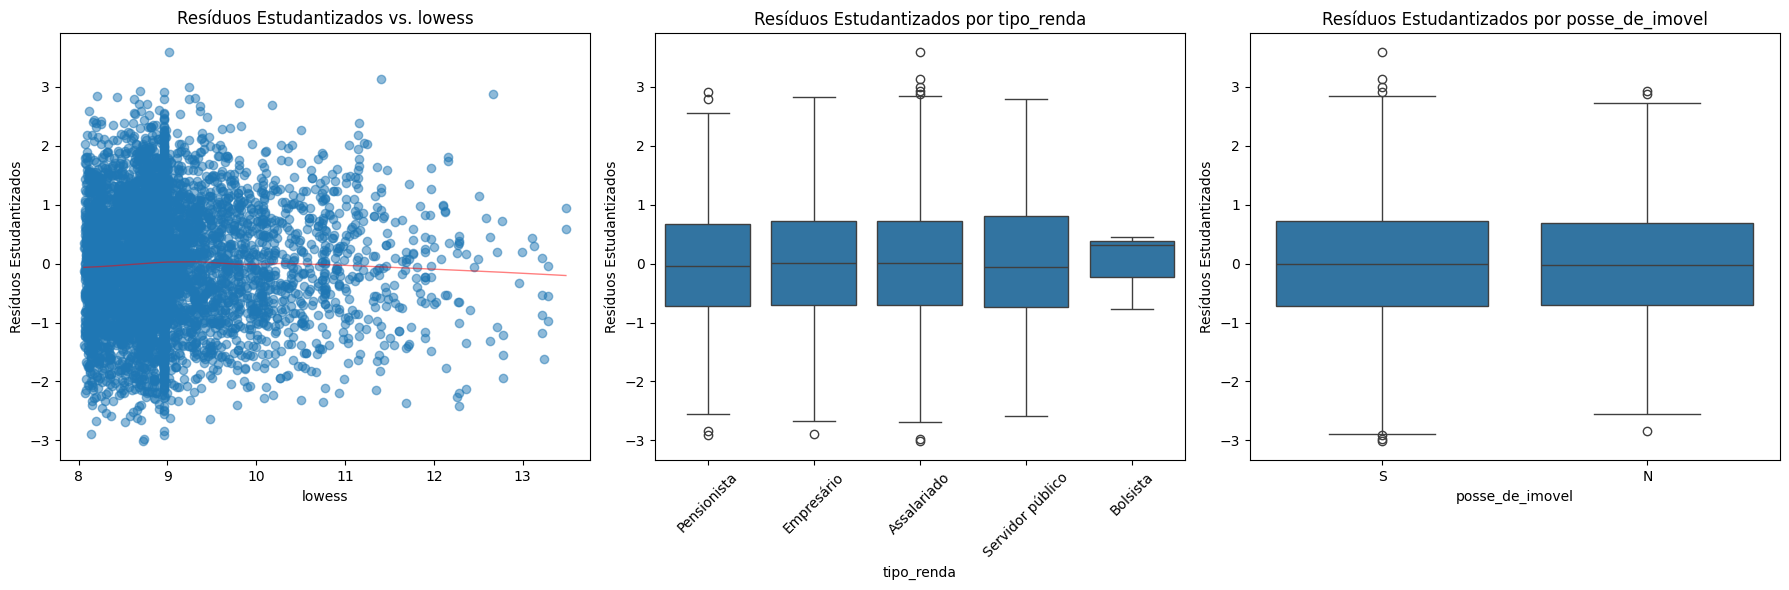

CPU times: user 1.02 s, sys: 42.4 ms, total: 1.06 s
Wall time: 1.15 s


In [29]:
%%time

# Cria uma figura com três gráficos para analisar os resíduos estudantizados em relação às variáveis do modelo de regressão múltipla
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

# Gráfico de Dispersão: Resíduos Estudantizados vs. 'lowess'
sns.regplot(ax=ax[0], x=df_train.lowess, y=outlier_test.student_resid, lowess=True, 
            scatter_kws={"alpha": 0.5}, line_kws={"color": "red", "lw": 1, "alpha": 0.5})
ax[0].set(title="Resíduos Estudantizados vs. lowess", xlabel="lowess", ylabel="Resíduos Estudantizados")

# Gráfico de Boxplot: Resíduos Estudantizados por 'tipo_renda'
sns.boxplot(ax=ax[1], x=df_train.tipo_renda, y=outlier_test.student_resid)
ax[1].set(title="Resíduos Estudantizados por tipo_renda", xlabel="tipo_renda", ylabel="Resíduos Estudantizados")
ax[1].tick_params(axis="x", rotation=45)  # Rotaciona rótulos do eixo x

# Gráfico de Boxplot: Resíduos Estudantizados por 'posse_de_imovel'
sns.boxplot(ax=ax[2], x=df_train.posse_de_imovel, y=outlier_test.student_resid)
ax[2].set(title="Resíduos Estudantizados por posse_de_imovel", xlabel="posse_de_imovel", ylabel="Resíduos Estudantizados")

# Exibe os gráficos
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

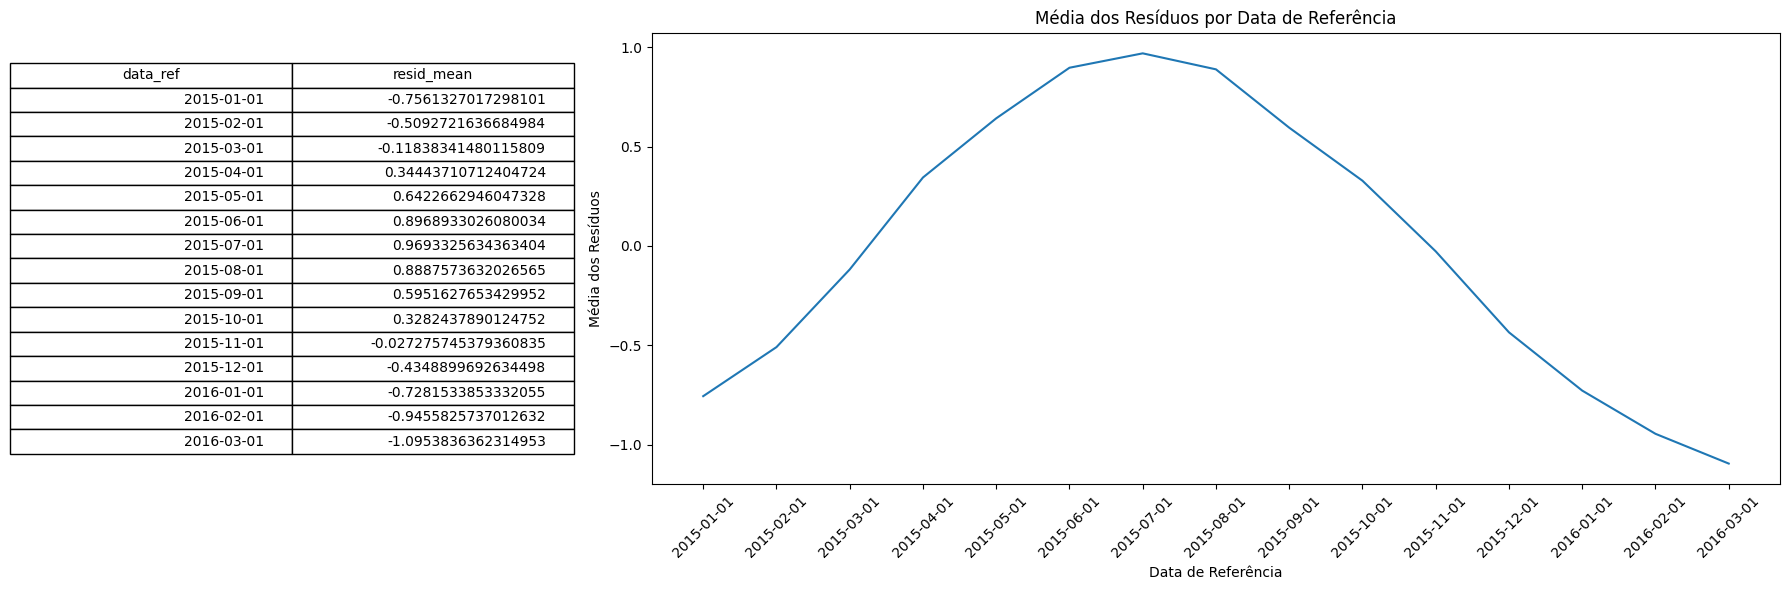

In [32]:
# Avalia se a média dos resíduos tem relação com o mês de referência

# Cria o DataFrame df_resid com resíduos associados à data de referência
df_resid = df_train[["data_ref"]].assign(resid=reg_multi.resid)

# Calcula a média dos resíduos por data de referência
df_resid_mean = df_resid.groupby("data_ref")["resid"].mean().reset_index(name="resid_mean")

# Cria o layout com plt.subplots() para exibir a tabela e o gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={"width_ratios": [1, 2]})

# Exibe a tabela de médias dos resíduos à esquerda
ax1.axis("off")
table = ax1.table(cellText=df_resid_mean.values, colLabels=df_resid_mean.columns, loc="center")
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Cria o gráfico de linha à direita
sns.lineplot(data=df_resid_mean, x="data_ref", y="resid_mean", ax=ax2)
ax2.set(title="Média dos Resíduos por Data de Referência", xlabel="Data de Referência", ylabel="Média dos Resíduos")
plt.xticks(rotation=45)

# Ajusta o layout
plt.tight_layout()
plt.show()

As suposições do modelo não estão completamente atendidas, conforme observamos:

1. **Distribuição dos Resíduos**: A forma dos resíduos (a diferença entre os valores reais e previstos) sugere uma distribuição normal, o que é um sinal positivo.
2. **Gráfico de Resíduos**: A dispersão dos resíduos indica alguns problemas. Observa-se que a variância dos resíduos não é constante em todas as predições, sugerindo a presença de heterocedasticidade.
3. **Relação com a Data de Referência**: Existe uma relação evidente entre os resíduos e a data de referência. Isso indica que o modelo pode não estar capturando adequadamente a variação temporal, o que pode comprometer a precisão das previsões.
> Em resumo, o modelo pode necessitar de ajustes para lidar melhor com a variação ao longo do tempo e para garantir que a variância dos resíduos permaneça constante.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

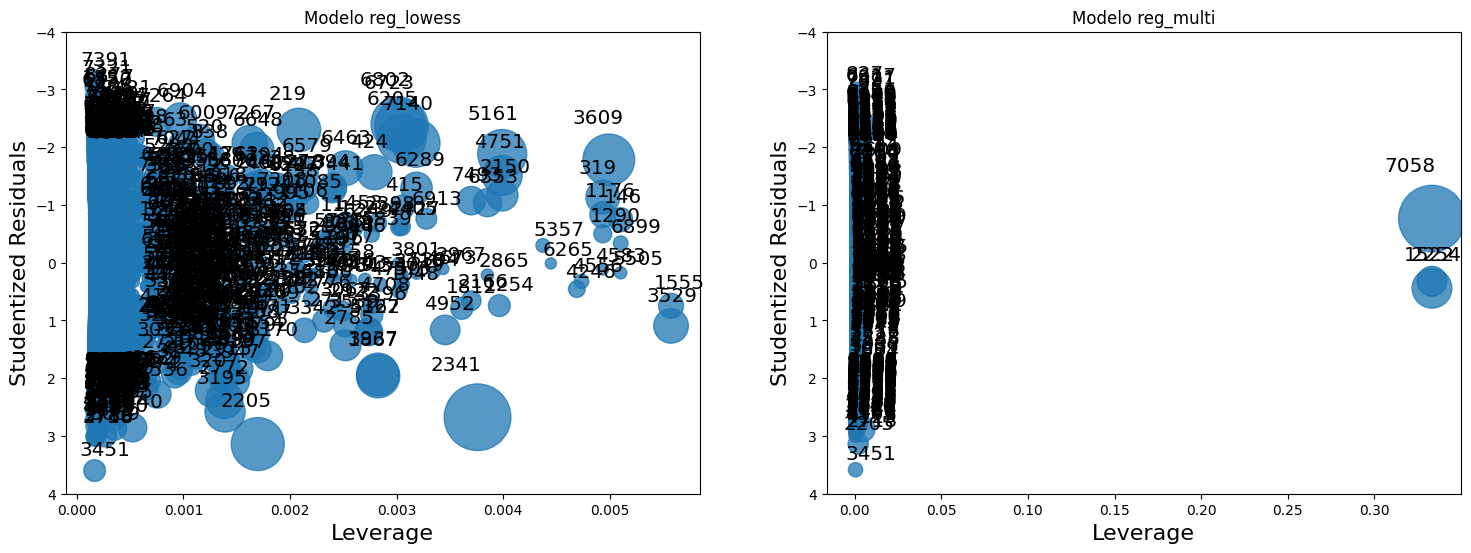

In [33]:
# Avaliando os resíduos estudantizados e identificando pontos discrepantes

# Cria uma figura com dois gráficos para analisar a influência nos modelos de regressão
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

# Gráfico de influência para o modelo reg_lowess
sm.graphics.influence_plot(reg_lowess, criterion="cooks", ax=ax[0])
ax[0].set(title="Modelo reg_lowess", ylim=(
    np.ceil(np.max(reg_lowess.get_influence().resid_studentized_internal)), 
    np.floor(np.min(reg_lowess.get_influence().resid_studentized_internal))
))

# Gráfico de influência para o modelo reg_multi
sm.graphics.influence_plot(reg_multi, criterion="cooks", ax=ax[1])
ax[1].set(title="Modelo reg_multi", ylim=(
    np.ceil(np.max(reg_multi.get_influence().resid_studentized_internal)), 
    np.floor(np.min(reg_multi.get_influence().resid_studentized_internal))
))

# Exibe os gráficos
plt.show()


In [34]:
%%time

# Exibe a contagem de observações para cada combinação de 'tipo_renda' e 'posse_de_imovel'
display(df_train.groupby(["tipo_renda", "posse_de_imovel"]).size().reset_index(name="qtd"))

# Calcula a alavancagem (leverage) para cada observação com base no modelo de regressão múltipla
df_train["leverage"] = reg_multi.get_influence().hat_matrix_diag

# Exibe as observações com alavancagem maior que 0.2
high_leverage = df_train[df_train.leverage > 0.2]
display(high_leverage)

# Exibe a contagem de observações com alta alavancagem por combinação de 'tipo_renda' e 'posse_de_imovel'
display(high_leverage.groupby(["tipo_renda", "posse_de_imovel"]).size().reset_index(name="qtd"))


,tipo_renda,posse_de_imovel,qtd
0,Assalariado,N,1112
1,Assalariado,S,1980
2,Bolsista,S,3
3,Empresário,N,456
4,Empresário,S,909
5,Pensionista,N,257
6,Pensionista,S,743
7,Servidor público,N,210
8,Servidor público,S,330


,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,lowess,leverage
1522,2015-04-01,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,10200.21,9.230164,9.421858,0.333333
2254,2015-05-01,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,9221.76,9.129321,9.421858,0.333333
7058,2016-03-01,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,3766.03,8.233777,9.421858,0.333333


,tipo_renda,posse_de_imovel,qtd
0,Bolsista,S,3


CPU times: user 34.5 ms, sys: 22.6 ms, total: 57.1 ms
Wall time: 62.2 ms


In [37]:
%%time

# Filtrando os dados para remover as observações onde 'tipo_renda' é 'Bolsista'
df_train = df_train[df_train["tipo_renda"] != "Bolsista"].copy()
df_test = df_test[df_test["tipo_renda"] != "Bolsista"].copy()

# Calculando os resíduos estudantizados para o DataFrame de treino
df_train["student_resid"] = outlier_test.student_resid

# Removendo observações com resíduos estudantizados fora do intervalo [-2, 2]
df_train = df_train[(df_train["student_resid"].between(-2, 2))]

# Exibindo as dimensões dos DataFrames de treino e teste após a filtragem
print(df_train.shape)
print(df_test.shape)

(5759, 17)
(1500, 15)
CPU times: user 7.32 ms, sys: 2.63 ms, total: 9.95 ms
Wall time: 8.69 ms


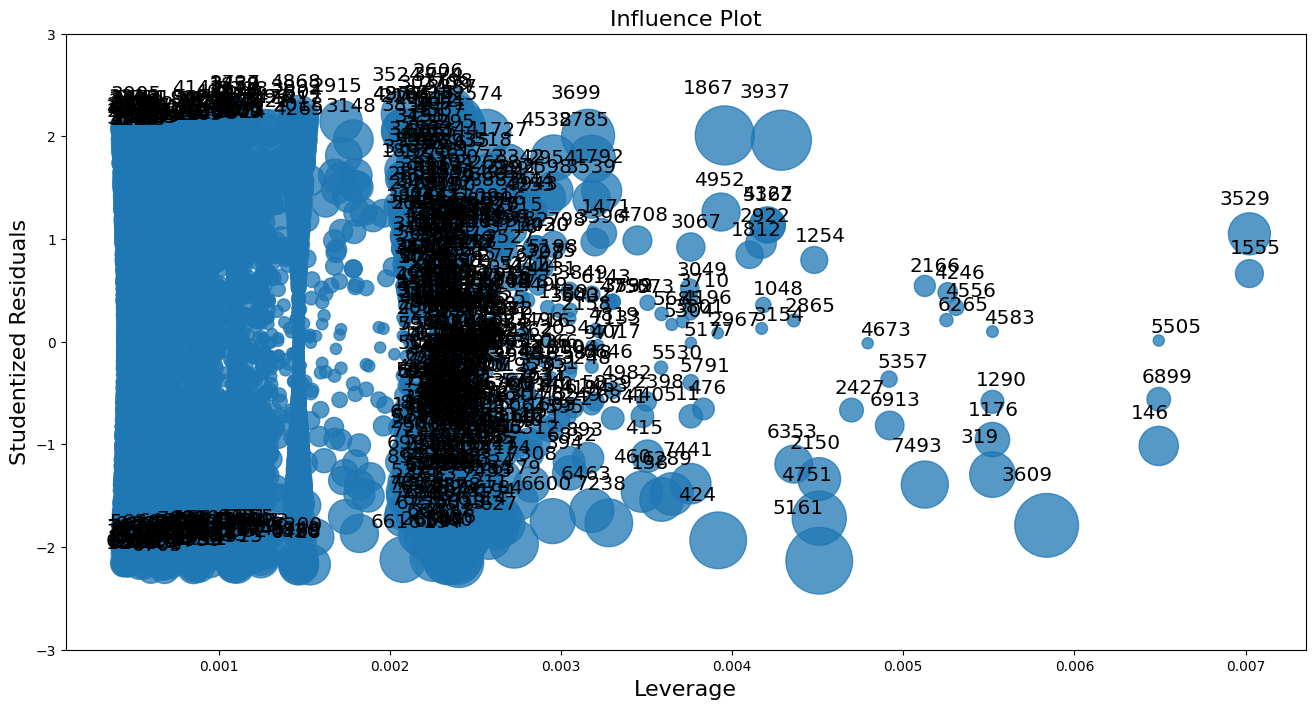

CPU times: user 11 s, sys: 1.4 s, total: 12.4 s
Wall time: 11.1 s


In [38]:
%%time

# Criando uma figura com um gráfico para analisar a influência dos pontos no modelo de regressão múltipla
fig, ax = plt.subplots(figsize=(16,8))

# Criando o gráfico de influência para o modelo de regressão múltipla utilizando o critério de Cook's Distance para identificar pontos discrepantes ou influentes
# Os dados utilizados são do DataFrame de treino após a filtragem
sm.graphics.influence_plot(results=smf.ols(formula="renda_log ~ lowess + tipo_renda + posse_de_imovel", data=df_train).fit(), criterion="cooks", ax=ax)

# Ajustando os limites do eixo y para focar na faixa de influência de -3 a 3
plt.ylim(-3, 3)

# Exibindo o gráfico
plt.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

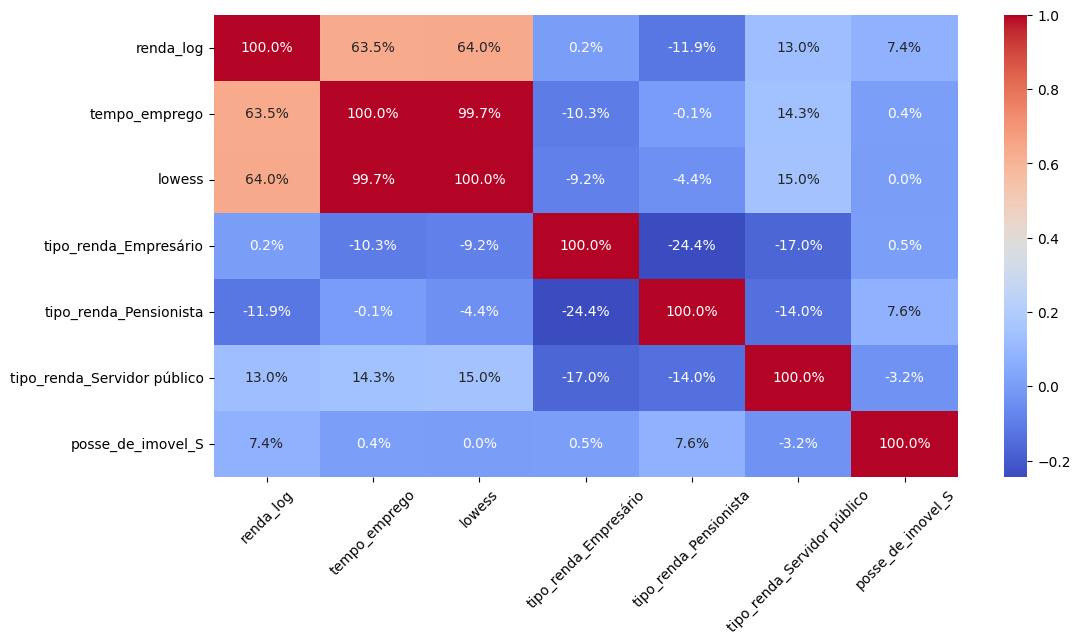

In [39]:
# Criando a matriz de correlação de Pearson para variáveis selecionadas
plt.figure(figsize=(12, 6))

# Calcula a correlação de Pearson e cria o heatmap
sns.heatmap(
    pd.get_dummies(df_train[["renda_log", "tempo_emprego", "lowess", "tipo_renda", "posse_de_imovel"]], drop_first=True).corr(),
    annot=True, fmt=".1%", cmap="coolwarm"
)

# Ajustando a rotação dos rótulos do eixo x
plt.xticks(rotation=45)

# Exibindo o gráfico
plt.show()


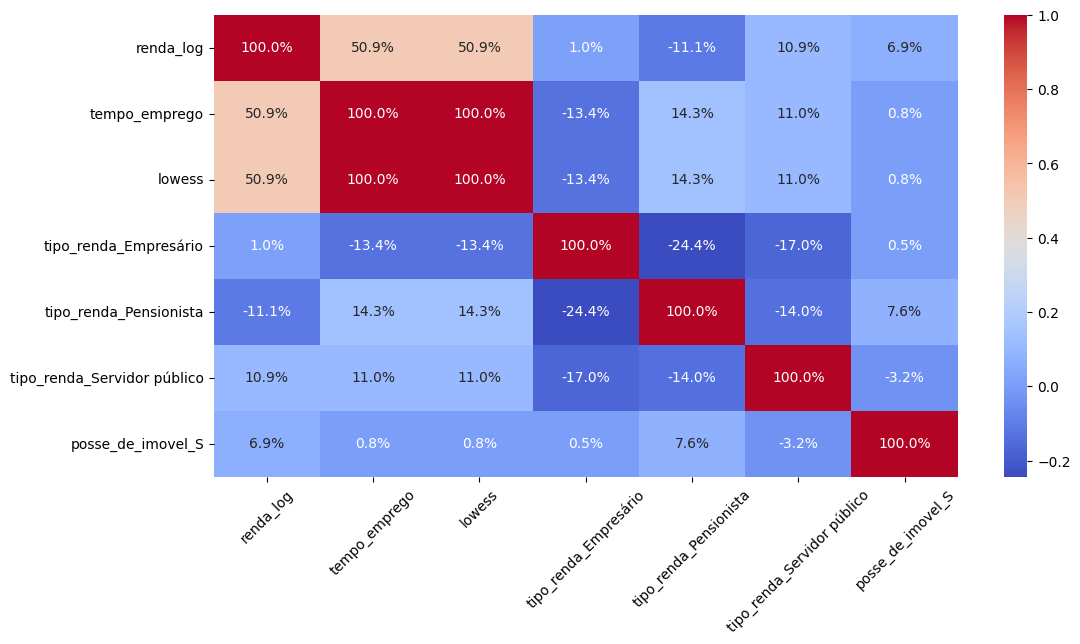

In [40]:
# Criando a matriz de correlação de Spearman para variáveis selecionadas
plt.figure(figsize=(12, 6))

# Calcula a correlação de Spearman e cria o heatmap
sns.heatmap(
    pd.get_dummies(df_train[["renda_log", "tempo_emprego", "lowess", "tipo_renda", "posse_de_imovel"]], drop_first=True).corr(method="spearman"),
    annot=True, fmt=".1%", cmap="coolwarm"
)

# Ajustando a rotação dos rótulos do eixo x
plt.xticks(rotation=45)

# Exibindo o gráfico
plt.show()


In [43]:
# Calculando o Fator de Inflação da Variância (VIF) para detectar multicolinearidade

# Definindo as colunas para as quais o VIF será calculado
columns = ["tempo_emprego", "posse_de_imovel", "tipo_renda"]

# Criando variáveis dummies e calculando o VIF
df_train_dummies = pd.get_dummies(data=df_train[columns], drop_first=True, dtype=int)

# Calculando o VIF para cada variável independente
df_vif = pd.DataFrame({
    "VIF Factor": [vif(df_train_dummies, i) for i in range(df_train_dummies.shape[1])],
    "Feature": df_train_dummies.columns
})

# Exibindo o DataFrame com os fatores de VIF arredondados
df_vif.round(2)


,VIF Factor,Feature
0,1.90,tempo_emprego
1,1.99,posse_de_imovel_S
2,1.26,tipo_renda_Empresário
3,1.25,tipo_renda_Pensionista
4,1.16,tipo_renda_Servidor público


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

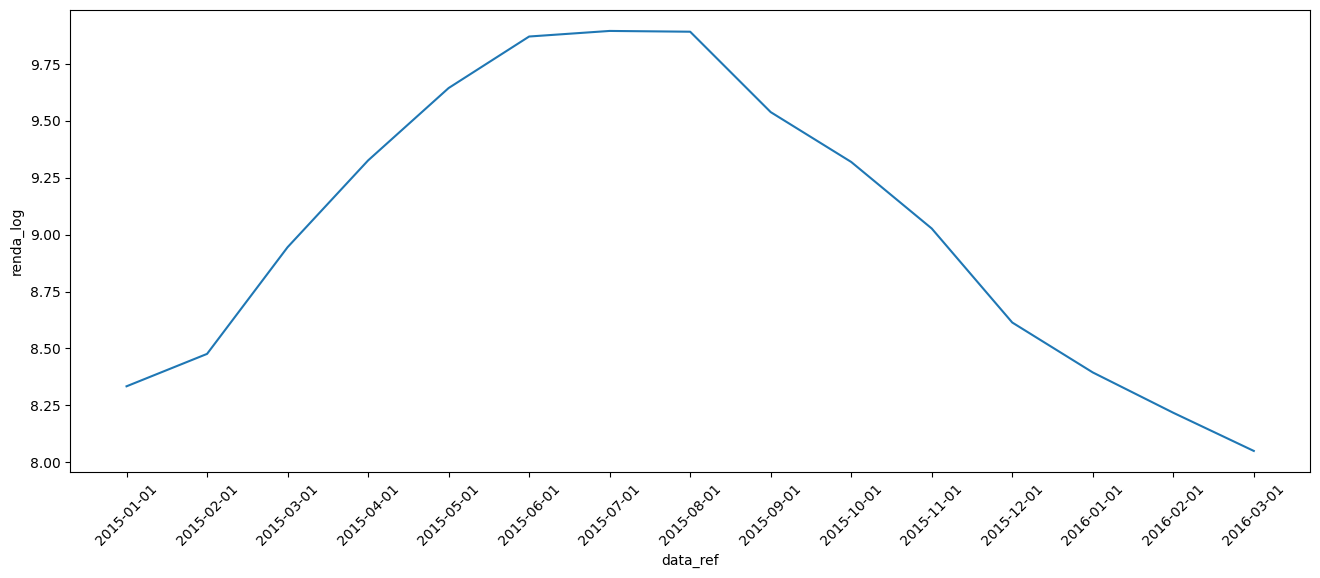

In [44]:
# Criando um gráfico de linha para mostrar a média de 'renda_log' ao longo do tempo (data_ref)

plt.figure(figsize=(16, 6))  # Tamanho da figura

# Agrupa os dados por 'data_ref' e calcula a média de 'renda_log'
sns.lineplot(data=df_train.groupby("data_ref").renda_log.mean())

# Rotaciona os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Exibe o gráfico
plt.show()


In [45]:
# Ajustando 'renda_log' para remover a influência de 'data_ref'
df_train["renda_log_data_ref"] = df_train.renda_log - df_train.groupby("data_ref")["renda_log"].transform("mean")

# Exibindo o DataFrame com a nova coluna 'renda_log_data_ref'
df_train


,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,lowess,leverage,student_resid,renda_log_data_ref
543,2015-02-01,F,N,S,0,Pensionista,Médio,Casado,Casa,65,7.666518,2.0,2468.74,7.811463,8.959169,0.001049,-0.963003,-0.664801
1526,2015-04-01,F,N,S,1,Empresário,Médio,Solteiro,Casa,31,1.783562,2.0,5960.13,8.692848,8.296036,0.000920,0.184630,-0.633531
4680,2015-10-01,F,N,S,0,Assalariado,Superior completo,Separado,Casa,41,9.016438,1.0,21684.23,9.984341,9.154541,0.000423,0.764383,0.664663
6868,2016-02-01,F,N,S,0,Pensionista,Médio,Casado,Casa,61,7.666518,2.0,2433.88,7.797242,8.959169,0.001049,-0.977064,-0.420302
891,2015-02-01,F,N,S,0,Assalariado,Médio,Casado,Casa,44,15.936986,2.0,6074.95,8.711929,10.209409,0.000793,-1.526836,0.235665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,2015-10-01,F,N,S,0,Assalariado,Médio,Casado,Casa,47,6.830137,2.0,5298.50,8.575179,8.870658,0.000430,-0.350230,-0.744499
4671,2015-10-01,M,S,S,0,Pensionista,Médio,Casado,Casa,58,7.666518,2.0,13043.06,9.476011,8.959169,0.001049,0.682606,0.156333
4486,2015-09-01,F,N,S,0,Assalariado,Superior completo,Viúvo,Casa,47,0.389041,1.0,2825.32,7.946377,8.087538,0.000686,-0.204678,-1.592377
5192,2015-11-01,F,N,S,0,Empresário,Médio,Casado,Casa,53,4.797260,2.0,6944.02,8.845636,8.699864,0.000828,-0.059945,-0.181672


In [46]:
# Realizando uma nova regressão linear múltipla
reg_ajuste = smf.ols("renda_log_data_ref ~ tempo_emprego + C(tipo_renda) + C(posse_de_imovel)", data=df_train).fit()

# Exibindo o resumo dos resultados
reg_ajuste.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     renda_log_data_ref   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1510.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:45:52   Log-Likelihood:                -5970.5
No. Observations:                5759   AIC:                         1.195e+04
Df Residuals:                    5753   BIC:                         1.199e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.1245      0.021    -53.227      0.000      -1.166      -1.083
C(tipo_renda)[T.Empresário]           0.1349      0.023      5.946      0.000       0.090       0.179
C(tipo_renda)[T.Pensionista]         -0.2835      0.025    -11.167      0.000      -0.333      -0.234
C(tipo_renda)[T.Servidor público]     0.1440      0.033      4.370      0.000       0.079       0.209
C(posse_de_imovel)[T.S]               0.2045      0.019     10.720      0.000       0.167       0.242
tempo_emprego                         0.1291      0.002     83.726      0.000       0.126       0.132
==============================================================================
Omnibus:                       17.273   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.693
Skew:                          -0.017   Prob(JB):                      0.00106
Kurtosis:                       2.764   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Calcula a média de 'renda_log' por 'data_ref'
data_map = df_train.groupby('data_ref')['renda_log'].mean()

# Estima 'renda_log' para o DataFrame de teste
renda_log_pred = df_test['data_ref'].map(data_map) + reg_ajuste.predict(df_test)

# Calcula e exibe o coeficiente de determinação (R²)
r2 = r2_score(df_test['renda_log'], renda_log_pred)
print(f"{r2:.2%}")


67.50%
